In [40]:
# Uncomment only if you want to reprocess the raw data using initial_prep.py
# The script will re-create crashes.gz, comma separated gzipped file in ../data/processed

## %run ../src/preprocessing/initial_prep.py

In [41]:
%run ../src/import_libraries.py

%matplotlib inline

In [42]:

full_df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)

In [43]:
sample_df=full_df.sample(80000, random_state=100)
#sample_df=full_df.copy()

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size=0.25, stratify=y)

nominal_columns = [ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER']

X_train = X_train[nominal_columns]
X_test = X_test[nominal_columns]


# bagging KNN

In [44]:


X_train=X_train.apply(LabelEncoder().fit_transform)
X_test=X_test.apply(LabelEncoder().fit_transform)

In [45]:
knn_bag_pipe = Pipeline([
                          ('std_scaler', StandardScaler()),
                          ('model', KNeighborsClassifier( n_jobs=-1 , 
                                        n_neighbors=100, weights='uniform', p=1))
                              ])
knn_bag_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=100, p=1))])

In [46]:

pipe_grid = {}
gs_pipe = GridSearchCV(estimator=knn_bag_pipe, 
                       param_grid=pipe_grid, cv=2, scoring='roc_auc')



In [47]:
gs_pipe.fit(X_train, y_train)
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [48]:
gs_pipe.score(X_train, y_train)

0.8418251411474823

In [49]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     38701
           1       0.71      0.65      0.68     21299

    accuracy                           0.78     60000
   macro avg       0.77      0.75      0.76     60000
weighted avg       0.78      0.78      0.78     60000

------------
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     12900
           1       0.71      0.65      0.68      7100

    accuracy                           0.78     20000
   macro avg       0.76      0.75      0.76     20000
weighted avg       0.78      0.78      0.78     20000



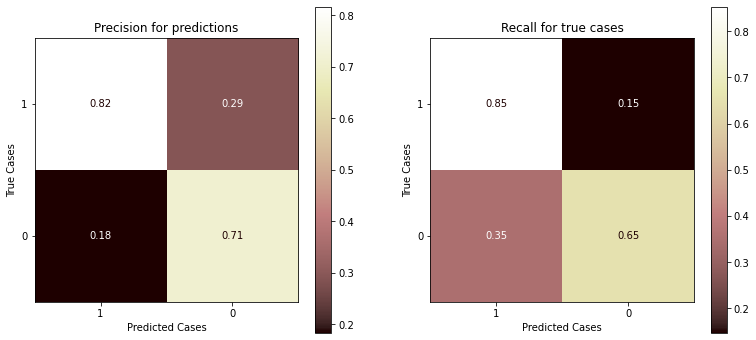

In [50]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

# Bayesian

In [51]:


cat_pipeline = Pipeline([
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
         ('std_scaler', StandardScaler()),
    
    ])


fu = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
    ])

In [52]:
bayesian_pipe = Pipeline([
                          ('fu', fu),
                          ('model', BaggingClassifier(QuadraticDiscriminantAnalysis(), 
                                                      n_estimators=100, ))
 
                              ])
pipe_grid = {}

gs_pipe = GridSearchCV(estimator=bayesian_pipe,
                       param_grid=pipe_grid, cv=5)
gs_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('cat_pipeline',
                                                                        Pipeline(steps=[('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False)),
                                                                                        ('std_scaler',
                                                                                         StandardScaler())]))])),
                                       ('model',
                                        BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(),
                                                          n_estimators=100))]),
             param_grid={})

In [53]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [54]:
print(gs_pipe.score(X_train, y_train ))
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

0.36846666666666666
              precision    recall  f1-score   support

           0       0.82      0.03      0.05     38701
           1       0.36      0.99      0.53     21299

    accuracy                           0.37     60000
   macro avg       0.59      0.51      0.29     60000
weighted avg       0.66      0.37      0.22     60000

------------
              precision    recall  f1-score   support

           0       0.61      0.20      0.31     12900
           1       0.35      0.77      0.48      7100

    accuracy                           0.40     20000
   macro avg       0.48      0.49      0.39     20000
weighted avg       0.52      0.40      0.37     20000



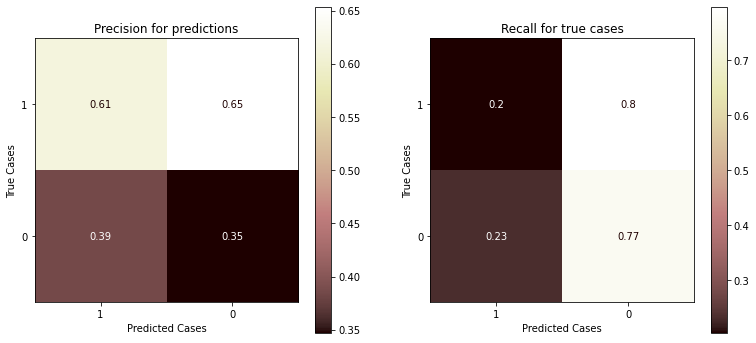

In [55]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

### Bayesian Model demonstrated a poor performance possibly because the correlation between predictors

# Extra Tree Forest

In [56]:
#sample_df=selected_df.sample(200000, random_state=100)
sample_df=full_df.copy()


y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size=0.25, stratify=y)


nominal_columns = [ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER']

X_train = X_train[nominal_columns]
X_test = X_test[nominal_columns]

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
    ])


In [58]:
extra_tree_pipe = Pipeline([
                          ('fu', fu),
                          ('model', ExtraTreesClassifier( max_depth=13, min_samples_leaf=3, 
                                                         min_samples_split=6, n_estimators=150 )),
                              ])

pipe_grid = {}

gs_pipe = GridSearchCV(estimator=extra_tree_pipe, 
                       param_grid=pipe_grid, cv=2, scoring='roc_auc')

In [59]:
gs_pipe.fit(X_train, y_train)
#gs_pipe.best_params_

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['FIRST_CRASH_TYPE',
                                                                                                                            'FIRST_CONTACT_POINT',
                                                                                                                            'MANEUVER'])),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('model',
                                        ExtraTreesClassifier(max_depth=13,
                                                             min_samples_leaf=3,
                                                             min_samples_split=6,
                                                             n_estimators=150))]),
             param_grid={}, scoring='roc_auc')

In [60]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [61]:
gs_pipe.score(X_train, y_train)

0.846530375410339

In [62]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84    167884
           1       0.74      0.62      0.67     93447

    accuracy                           0.79    261331
   macro avg       0.77      0.75      0.76    261331
weighted avg       0.78      0.79      0.78    261331

------------
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     55962
           1       0.73      0.62      0.67     31149

    accuracy                           0.78     87111
   macro avg       0.77      0.75      0.75     87111
weighted avg       0.78      0.78      0.78     87111



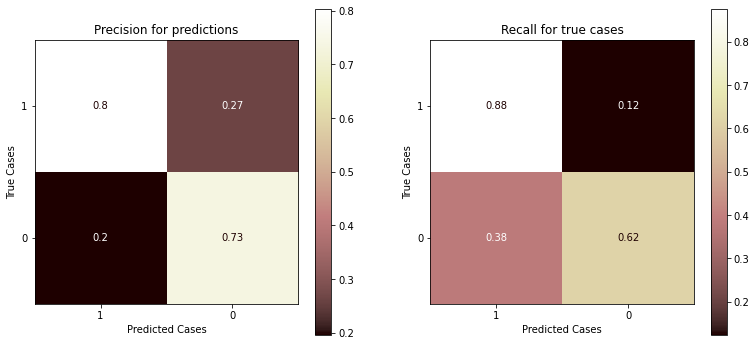

In [63]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

In [64]:
# KNN and ExtraForest marginally worse than LogisticRegression and Random Forest, but very similar

In [65]:
## Bayesian is much worse, most likely because of correlation between predictors